<a href="https://colab.research.google.com/github/tkasod2/TIL/blob/main/prj_analysis/Retailrocket_recommender_system_datase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data link : https://www.kaggle.com/retailrocket/ecommerce-dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

# !unzip -qq '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store.zip' -d '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store'

# # GPU Check
# !nvidia-smi

# # CPU Check
# !head /proc/cpuinfo

# # RAM
# !head -n 3 /proc/meminfo

Mounted at /content/drive


In [2]:
import pandas as pd
import os

In [3]:
PATH = '/content/drive/MyDrive/공부/Kaggle/Retailrocket recommender system dataset/'

FILES = list(os.listdir(PATH))
FILES = [x.split('.csv')[0] for x in FILES]

def readcsv(x):
  return pd.read_csv(PATH + x)

for i in FILES:
  globals()[f'df_{i}'] = readcsv(i+'.csv')

In [4]:
import datetime
def ts_to_dt(df):
  for col in df.columns:
    if col == 'timestamp':
      df['datetime'] = (df['timestamp']/1000).apply(datetime.datetime.fromtimestamp) # timestamp에서 datetime 으로 바꿀때 1000을 나눠줘야한다.
      df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
    else:
      pass
  return df

In [5]:
events = ts_to_dt(df_events)

,timestamp,visitorid,event,itemid,transactionid,datetime,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02


In [7]:
item_pro1 = ts_to_dt(df_item_properties_part1)
item_pro2 = ts_to_dt(df_item_properties_part2)
item_pro2.head()

,timestamp,itemid,property,value,datetime,date
0,1433041200000,183478,561,769062,2015-05-31 03:00:00,2015-05-31
1,1439694000000,132256,976,n26.400 1135780,2015-08-16 03:00:00,2015-08-16
2,1435460400000,420307,921,1149317 1257525,2015-06-28 03:00:00,2015-06-28
3,1431831600000,403324,917,1204143,2015-05-17 03:00:00,2015-05-17
4,1435460400000,230701,521,769062,2015-06-28 03:00:00,2015-06-28


In [11]:
df_item = pd.concat([item_pro1, item_pro2],ignore_index = True)
df_item.head()

,timestamp,itemid,property,value,datetime,date
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00,2015-06-28
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00,2015-09-06
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00,2015-08-09
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00,2015-05-10
4,1431831600000,156781,917,828513,2015-05-17 03:00:00,2015-05-17


In [38]:
events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid',
       'datetime', 'date'],
      dtype='object')

### events

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

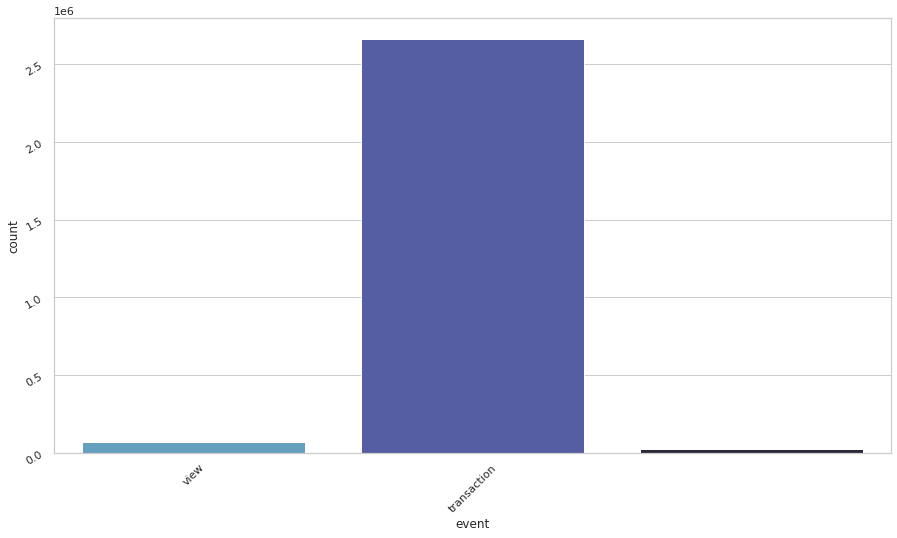

In [55]:
# events['event']
sns.set_theme(style="whitegrid", palette="icefire")
plt.xticks(rotation=45)
plt.yticks(rotation=30) 

g = sns.countplot(x='event',data =events)
g.figure.set_size_inches(15, 8) # 그래프의 크기를 키운다
g.xaxis.set_major_locator(ticker.MultipleLocator(1))


In [22]:
# event and transactionid
# # df['event'].value_counts()
# # # view           2664312
# # # addtocart        69332
# # # transaction      22457


# event가 transaction인 경우에만 transactionid가 존재한다.
events.groupby('event')['transactionid'].count().reset_index().rename(columns = {'transaction_id' :'cnt_transaction_id'})


,event,transactionid
0,addtocart,0
1,transaction,22457
2,view,0


In [35]:
events.sort_values('timestamp',inplace=True)
events.reset_index(drop=True, inplace = True)
events.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03


#### df_item

In [34]:
df_item.sort_values('timestamp',inplace=True)
df_item.reset_index(drop=True, inplace = True)
df_item.head()

,timestamp,itemid,property,value,datetime,date
0,1431226800000,317951,790,n32880.000,2015-05-10 03:00:00,2015-05-10
1,1431226800000,422842,480,1133979,2015-05-10 03:00:00,2015-05-10
2,1431226800000,310185,776,103591,2015-05-10 03:00:00,2015-05-10
3,1431226800000,110973,112,679677,2015-05-10 03:00:00,2015-05-10
4,1431226800000,179597,available,0,2015-05-10 03:00:00,2015-05-10


In [37]:
df_item[df_item['itemid']==243157]

,timestamp,itemid,property,value,datetime,date
19387056,1441508400000,243157,678,567465,2015-09-06 03:00:00,2015-09-06
19394072,1441508400000,243157,categoryid,333,2015-09-06 03:00:00,2015-09-06
19489934,1441508400000,243157,888,923712,2015-09-06 03:00:00,2015-09-06
19600934,1441508400000,243157,283,648307 567465 923712 659000 639502 312815 8107...,2015-09-06 03:00:00,2015-09-06
19604757,1441508400000,243157,790,n507120.000,2015-09-06 03:00:00,2015-09-06
19635543,1441508400000,243157,764,1285872,2015-09-06 03:00:00,2015-09-06
19806090,1442113200000,243157,112,679677,2015-09-13 03:00:00,2015-09-13
19811541,1442113200000,243157,6,250259 1037547,2015-09-13 03:00:00,2015-09-13
19937137,1442113200000,243157,364,1326957,2015-09-13 03:00:00,2015-09-13
19957934,1442113200000,243157,917,923712,2015-09-13 03:00:00,2015-09-13
